# Kschool TFM

## Prelude

The goal of this competition is to predict a Windows machine’s probability of getting infected by various families of malware, based on different properties of that machine. The telemetry data containing these properties and the machine infections was generated by combining heartbeat and threat reports collected by Microsoft's endpoint protection solution, Windows Defender.

Each row in this dataset corresponds to a machine, uniquely identified by a MachineIdentifier. HasDetections is the ground truth and indicates that Malware was detected on the machine. Using the information and labels in train.csv, you must predict the value for HasDetections for each machine in test.csv.

## Necessary imports

In [1]:
# disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# own classes
from Spark import InitSpark
import Resources as resources
import Utilities as utils
from DataGetter import DataGetter

In [3]:
# matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
# seaborn
import seaborn as sns

In [5]:
# sklearn and xgboost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, make_scorer, recall_score, roc_auc_score
from xgboost import XGBClassifier

In [58]:
# pandas & numpy & others
import pandas as pd
import numpy as np
import itertools

In [7]:
# sparkSQL
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [8]:
# sparkML
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import RandomForestClassifier as RFC
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

## Process Code

In [9]:
## basic configuration

ignore = False # If True, process will ignore fields marked as NA in README.md

score_dict = {
    'precision': make_scorer(precision_score),
    'accuracy': make_scorer(accuracy_score),
    'recall': make_scorer(recall_score),
    'auc' : make_scorer(roc_auc_score)
} # Scores for cross validation searches

classifier_dict = {
    'dtc': DecisionTreeClassifier,
    'rfc': RandomForestClassifier,
    'xgb': XGBClassifier    
} # Classifiers for cross validation searches

param_grid_dict = {
    'dtc': {
        'max_depth': range(1,10), 
    },
    'rfc': {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    },
    'xgb': {
        'max_depth': [2, 3, 5, 8, 10, 13, 18],
        'n_estimators': [10, 25, 50, 100]
    }    
} # Param grids for cross validation searches

classifier_names = {
    'dtc': 'Decision Tree Classifier',
    'rfc': 'Random Forest Classifier',
    'xgb': 'XGB Classifier'    
} # Classifiers names

score_refit = 'auc' # The cross validation searches will be refitted against this score. It should be in score_dict
schema = resources.df_schema # Schema from Resources.py for our model
types_default_values = resources.default_values # Default values for each dataType
cv = 3 # Loops in data for cross validation searches
n_iter = 30 # Number of parameter settings that are sampled in RandomizedSearchCV
sample_size = .01 # Size (percentage) from spark to pandas

options = {'header': 'true', 'delimiter': ','} # To read the csv file

cut_at = .01 # variable weight to be in model

train_df_transformed = None # aux initialization
test_df_transformed = None # aux initialization

In [10]:
def run_model(classifier, x_train, y_train, random=False):
    """Given a classifier, x_train and y_train this methos fits a model using GridSearchCV or RandomizedSearchCV if random=True"""
    print("Running for %s" % classifier_names[classifier])
    if not random:
        model = utils.get_grid_search_cv(classifier=classifier_dict[classifier],
                                   param_grid=param_grid_dict[classifier],
                                   score_dict=score_dict,
                                   score_refit=score_refit,
                                   cv=cv)
    else:
        model = utils.get_randomized_search_cv(classifier=classifier_dict[classifier],
                                         param_grid=param_grid_dict[classifier],
                                         score_dict=score_dict,
                                         score_refit=score_refit,
                                         cv=cv,
                                         n_iter=n_iter)
    
    model.fit(x_train, y_train)
    utils.print_scores(model.cv_results_, scores=score_dict, score_refit=score_refit)
    print("Best Params = %s\n" % str(model.best_params_))
    return model

In [11]:
def transform_df(df):
    """This function helps you to transform String fields in a Spark DF into valid values for machine learning process."""  
    for field in in_model.keys():
        if (types[field] == StringType()):
            df = df.withColumn(field, lower(trim(col(field))))
    
    string_fields = [field for field in in_model.keys() if types[field] == StringType()]
    
    index_dict = {field: field + 'Index' for field in string_fields}
    
    indexers = [StringIndexer(inputCol=x, outputCol=index_dict[x]) for x in string_fields]
    
    pipeline = Pipeline(stages=indexers)
    
    df_transformed = pipeline.fit(df).transform(df)
    
    for field in string_fields:
        df_transformed = df_transformed.withColumn(field, col(index_dict[field])).drop(index_dict[field])
    
    return df_transformed

In [12]:
def heat_map(x_tags, y_tags, values, title):
    """Function to plot a heat map
    x_tags = labels for x axis
    y_tags = labels for y axis
    values = matrix of values, it should be x_len*y_len
    title = plot title"""
    fig, ax = plt.subplots(figsize=(40, 20))
    im = ax.imshow(values)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_tags)))
    ax.set_yticks(np.arange(len(y_tags)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_tags)
    ax.set_yticklabels(y_tags)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.set_title(title)
    fig.set_size_inches(40, 20)
    plt.show()

In [13]:
def bar(df, x, y, title):
    """Given a pandas df, bar plots column x and column y in a bar plot"""
    f, ax = plt.subplots()
    g = sns.barplot(x=x, y=y, data=df, ax=ax)
    ax.set_title(title)
    f.set_size_inches(15, 5)
    plt.show()

In [14]:
DataGetter().get_data()

In [15]:
spark = InitSpark().get_spark_session()
spark

In [16]:
train_df = spark.read.options(**options).schema(schema).csv(resources.train_path)

In [17]:
test_df = spark.read.options(**options).schema(schema).csv(resources.test_path)

In [18]:
types = utils.get_input_fields_dict(train_df, 'types')

**column_id**: MachineIdentifier

**x_fields**: Contains all column names in the df except **column_id** and **y_field**

**y_field**: Conatins target column name

**in_model**: Contains all column name in the df that we are going to use in our model. All True this point.

In [19]:
column_id, x_fields, y_field = utils.get_splitted_fields(schema)

In [20]:
in_model = utils.get_input_fields_dict(train_df, 'in_model')

In [21]:
df_default_values = utils.get_input_fields_dict(train_df, \
                                                'default_values', \
                                                default_values=types_default_values)

In [22]:
train_df = train_df.na.fill(df_default_values)
test_df = test_df.na.fill(df_default_values)

## Visualizing Data

The code below is comented because we have only executed it once. Output could be see in: 

***Analysis/Data:*** The data will be plotted

***Analysis/Plots/Normal:*** Plotted data in normal scale

***Analysis/Plots/Log:*** Plotted data in log scale

````
for each in in_model.keys():
    train_df.select(each, y_field) \
    .groupBy(col(each), col(y_field)) \
    .agg(count(lit(1)).alias("count")) \
    .repartition(1) \
    .write \
    .options(**options) \
    .csv("Analysis/%s" % each)
````

```
for each in in_model.keys():
    path = "Analysis/Data/%s.csv" % each
    analyzing_df = pd.DataFrame.from_csv(path, index_col=None).sort_values('count', ascending=False)
    for elem in ['Normal', 'Log']:
        if types[each] == StringType():
            f, ax = plt.subplots()
            sns.barplot(y=each, x='count', data=analyzing_df.head(40), hue='HasDetections', ax=ax)
            ax.set_xscale('log') if elem == 'Log' else None
            f.set_size_inches(15, 10)
            f.tight_layout()
            plt.savefig('Analysis/Plots/%s/%s.png' % (elem, each))
        else:
            analyzing_df = analyzing_df.sort_values(each, ascending=True)
            f, ax = plt.subplots()
            sns.barplot(x=each, y='count', data=analyzing_df.head(40), hue='HasDetections', ax=ax)
            ax.set_yscale('log') if elem == 'Log' else None
            f.set_size_inches(10, 15)
            f.tight_layout()
            plt.savefig('Analysis/Plots/%s/%s.png' % (elem, each))```

```
train_df.groupBy(col('HasDetections')).agg(count(lit(1))).show()
+-------------+--------+
|HasDetections|count(1)|
+-------------+--------+
|            1| 4013997|
|            0| 4015946|
+-------------+--------+```

The below variable could be loaded directly from ***Resources***. We only executed it once to avoid expensing so many time in it.
````
different_values = {k: train_df.select(k).distinct().count() for k in in_model.keys()}
````


Now, with **different_values** calculated, we are gonna decide which columns to use as input of our model.

In [23]:
columns = pd.DataFrame.from_dict(resources.different_values, orient='index', columns=['how_many'])

In [24]:
columns.describe()

,how_many
count,8.200000e+01
mean,1.207026e+05
std,9.859126e+05
min,2.000000e+00
25%,3.000000e+00
50%,1.350000e+01
75%,2.910000e+02
max,8.921483e+06


As we can see, a percentage of columns between 50 and 75 percent has no more than 100 different values, so, we are gonna update **in_model** to take only columns with less than 100 different values.

In [28]:
na_fields = utils.get_na_fields(ignore)

In [29]:
in_model = {k: True if ((resources.different_values[k] <= 100) and (k not in na_fields)) else False for k in in_model.keys()}

In [30]:
x_fields = utils.get_select_fields(in_model)

In [31]:
sample_train_df = utils.get_sample(train_df, x_fields + [y_field], sample_size)

Checking if target is still pondered

````
sample_train_df.groupBy(col(y_field)).agg(count(lit(1))).show()
+-------------+--------+
|HasDetections|count(1)|
+-------------+--------+
|            1|  445660|
|            0|  446209|
+-------------+--------+
````

Let's transform to lower case StringType fields:

In [32]:
for field in x_fields:
    if (types[field] == StringType()):
        sample_train_df = sample_train_df.withColumn(field, lower(trim(col(field))))

In [33]:
print("""
Model fields: %s
Target field: %s""" % (str(len(x_fields)), y_field))


Model fields: 55
Target field: HasDetections


In [34]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

In [35]:
x_train = pd.get_dummies(x_train)

## Let's fit our model

As a malware detector, we will use **roc_auc** over precision, accuracy or recall scores. In any case, we will execute the 4 scores to verify that the roc_auc is due to a successful criterion.

Running for Decision Tree Classifier
best_precision: 0.81333135, precision_based_on_best_auc: 0.62098288
best_accuracy: 0.6076451, accuracy_based_on_best_auc: 0.60737009
best_recall: 0.81301038, recall_based_on_best_auc: 0.58770814
best_auc: 0.60745481, auc_based_on_best_auc: 0.60745481


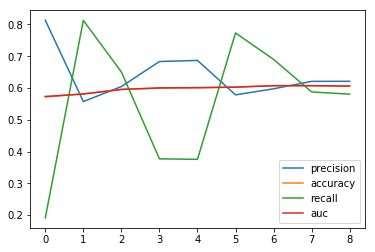

Best Params = {'max_depth': 8}

Running for Random Forest Classifier
best_precision: 0.63436146, precision_based_on_best_auc: 0.63436146
best_accuracy: 0.63047038, accuracy_based_on_best_auc: 0.63047038
best_recall: 0.71138731, recall_based_on_best_auc: 0.62323235
best_auc: 0.63050097, auc_based_on_best_auc: 0.63050097


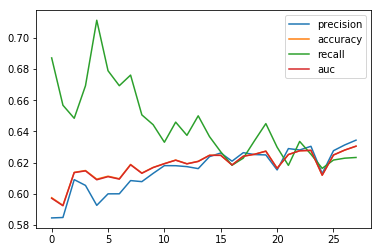

Best Params = {'max_depth': 18, 'n_estimators': 100}

Running for XGB Classifier
best_precision: 0.63258436, precision_based_on_best_auc: 0.63224616
best_accuracy: 0.62952037, accuracy_based_on_best_auc: 0.62952037
best_recall: 0.73483913, recall_based_on_best_auc: 0.62666798
best_auc: 0.62953245, auc_based_on_best_auc: 0.62953245


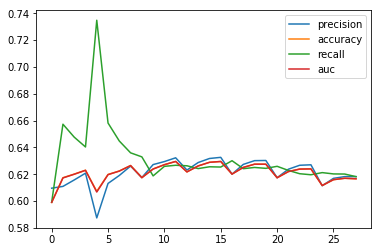

Best Params = {'max_depth': 5, 'n_estimators': 100}



In [36]:
_ = {classifier: run_model(classifier, x_train, y_train) for classifier in classifier_dict.keys()}

## Coming back

As we can see, our criteria to select columns in our model, has not been so efficient as we want, so we are gonna generate a correlation matrix over full data and take the higher values to select the fields.

In [44]:
train_df_transformed = transform_df(train_df)
test_df_transformed = transform_df(test_df)

In [45]:
assembler = VectorAssembler(inputCols=train_df_transformed.drop(column_id).columns, outputCol='features')

In [46]:
correlation_df = assembler.transform(train_df_transformed.drop(column_id))

In [47]:
correlation_array = Correlation.corr(correlation_df, "features").head()[0]

In [48]:
number_of_columns = len(train_df_transformed.drop(column_id).columns)

In [49]:
correlation_matrix = correlation_array.values.reshape(number_of_columns, number_of_columns)

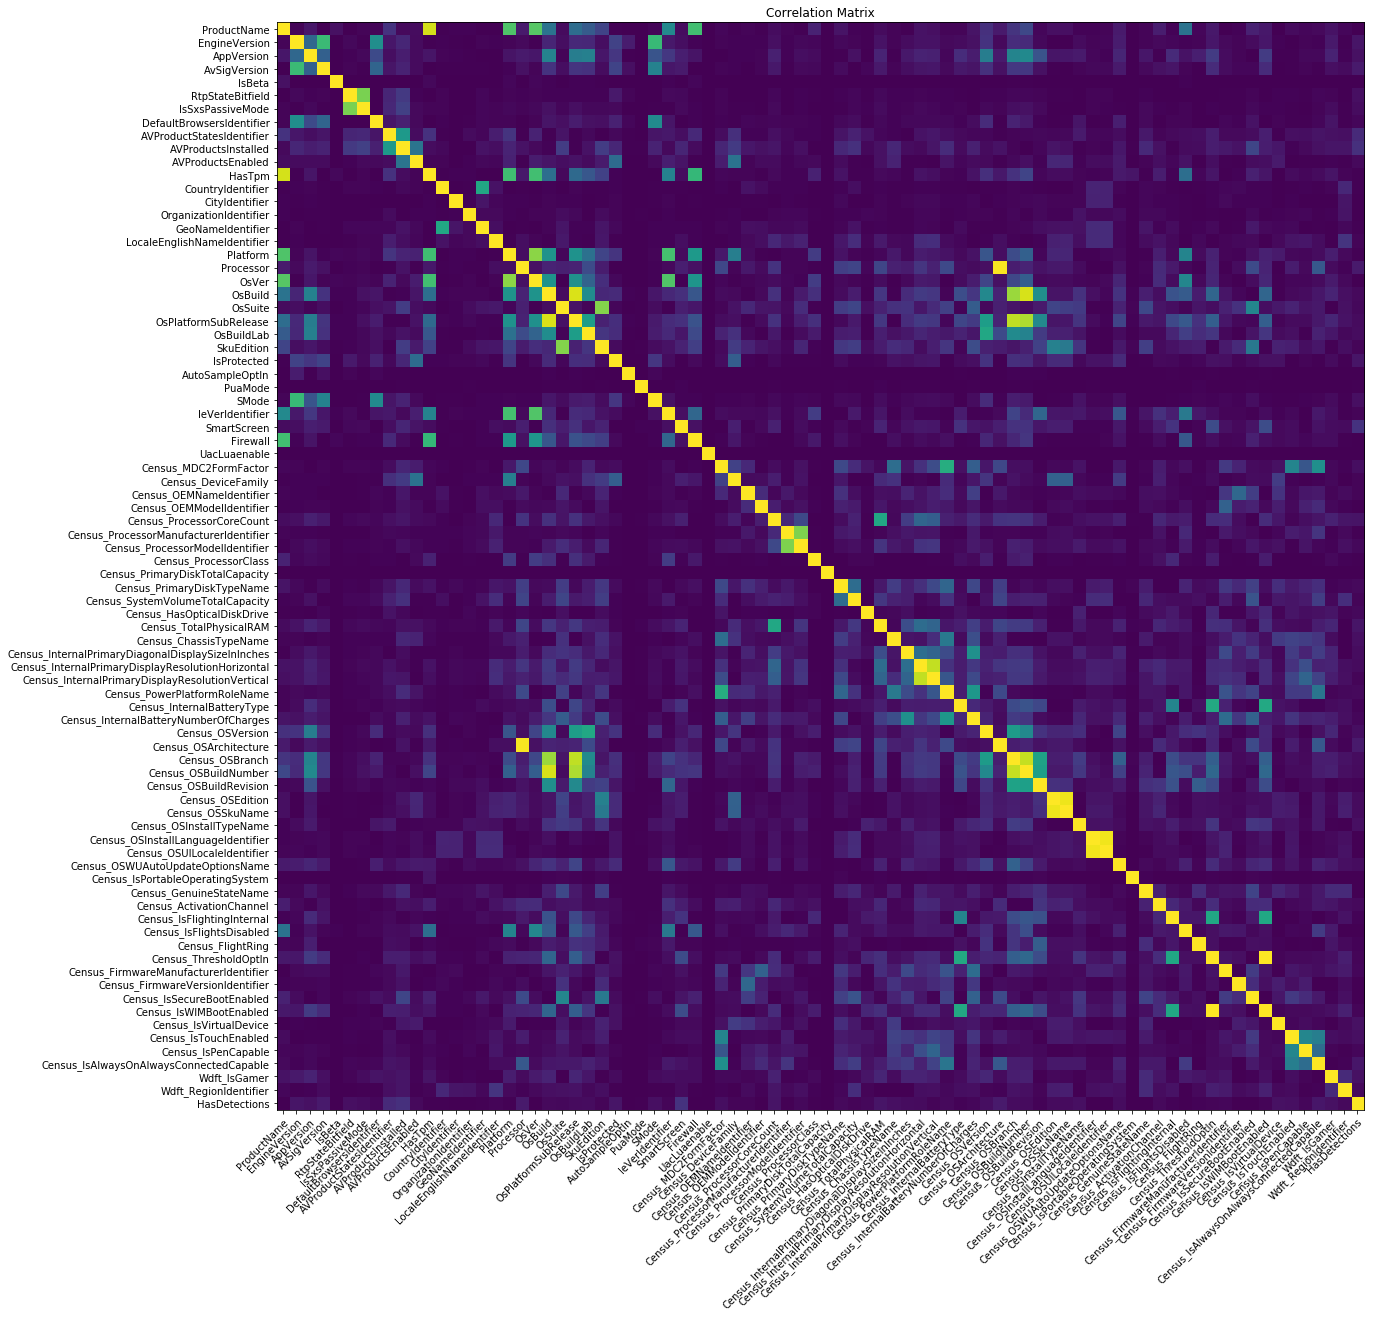

In [53]:
heat_map(train_df_transformed.drop(column_id).columns, train_df_transformed.drop(column_id).columns, __builtin__.abs(correlation_matrix), "Correlation Matrix")

Well, it's so dificult see the correlation between target and the other fields in the graph above, so let's print only correlation with **HasDetections** column

In [78]:
starting_point = (number_of_columns ** 2) - number_of_columns

In [79]:
correlation = utils.get_input_fields_dict(train_df_transformed.drop(column_id), \
                                           'correlation', \
                                           correlations=correlation_array.values[starting_point:-1])

In [80]:
correlation_ordered = utils.get_input_fields_dict(train_df_transformed.drop(column_id), \
                                                  'correlation_ordered', \
                                                  correlations=correlation_array.values[starting_point:-1])

In [81]:
correlations_pd = pd.DataFrame.from_dict(correlation, orient='index', columns=['correlation']).sort_values("correlation", ascending=False)

In [82]:
correlations_pd['feature'] = correlations_pd.index

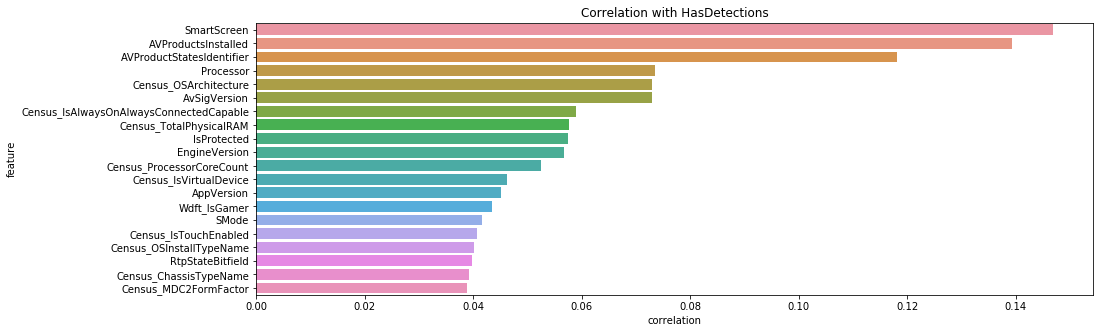

In [83]:
bar(correlations_pd.head(20), 'correlation', 'feature', 'Correlation with HasDetections')

### Let's try with top correlationed fields...

In [84]:
in_model = {k: ((correlation[k] >= cut_at) and (k not in na_fields)) for k in in_model.keys()}

In [86]:
x_fields = utils.get_select_fields(in_model)

In [87]:
sample_train_df = utils.get_sample(train_df_transformed, x_fields + [y_field], sample_size)

In [90]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

Running for Decision Tree Classifier
best_precision: 0.73107753, precision_based_on_best_auc: 0.60024512
best_accuracy: 0.61476206, accuracy_based_on_best_auc: 0.61476206
best_recall: 0.82326314, recall_based_on_best_auc: 0.67731206
best_auc: 0.61502729, auc_based_on_best_auc: 0.61502729


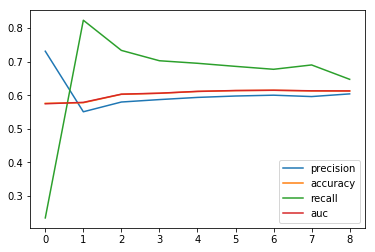

Best Params = {'max_depth': 7}

Running for Random Forest Classifier
best_precision: 0.62807398, precision_based_on_best_auc: 0.62807398
best_accuracy: 0.63245511, accuracy_based_on_best_auc: 0.63245511
best_recall: 0.68408943, recall_based_on_best_auc: 0.64189966
best_auc: 0.63249516, auc_based_on_best_auc: 0.63249516


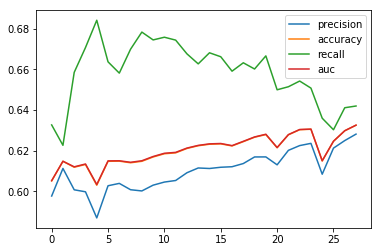

Best Params = {'max_depth': 18, 'n_estimators': 100}

Running for XGB Classifier
best_precision: 0.73413562, precision_based_on_best_auc: 0.63813797
best_accuracy: 0.63738576, accuracy_based_on_best_auc: 0.63738576
best_recall: 0.6774121, recall_based_on_best_auc: 0.62754464
best_auc: 0.63734403, auc_based_on_best_auc: 0.63734403


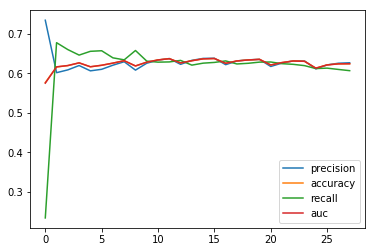

Best Params = {'max_depth': 8, 'n_estimators': 100}

CPU times: user 43.2 s, sys: 866 ms, total: 44.1 s
Wall time: 6min 35s


In [91]:
%%time
for classifier in classifier_dict.keys():
    run_model(classifier, x_train, y_train)

Well... This improve our metrics but let's do one more thing.

Let's try to predict with all the fields in our data to see which features are considered the most important.

As we can see, this process is so heavy (more than 90 minutes) son we will only take a 50% of our sample size.

The, we will compare most correlated values with the heaviest in each model and we will try to predict with Spark.


On the other hand, we can get some conclusions for each model:

1. **Decision tree**: The best measure is for the max value of max_depth, so we can increase it but we will not expect to improve much more, because graphic is so linear.

2. **Random Forest**: Our graphic still was growing when it reaches max values in the grid, so we can increase them.

3. **XGB**: We can see periodicity. if max_depth is greater than 10 our model gets worse. n_estimator has reaches it's maximum value but graphic is also so linear so we can suppose that {'max_depth': 10, 'n_estimators': 100} are the best params for XGB.

In [92]:
in_model = {k: True for k in in_model.keys()}

In [93]:
x_fields = utils.get_select_fields(in_model)

In [94]:
sample_train_df = utils.get_sample(train_df_transformed, x_fields + [y_field], sample_size)

In [95]:
x_train, y_train = utils.get_x_y_train(sample_train_df, x_fields, y_field)

Running for Decision Tree Classifier
best_precision: 0.72394083, precision_based_on_best_auc: 0.6109411
best_accuracy: 0.61093067, accuracy_based_on_best_auc: 0.61093067
best_recall: 0.76922884, recall_based_on_best_auc: 0.59720674
best_auc: 0.61083488, auc_based_on_best_auc: 0.61083488


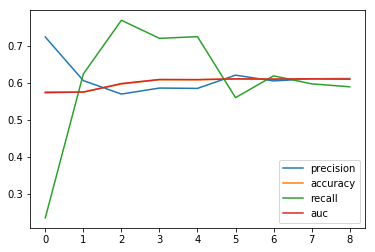

Best Params = {'max_depth': 8}

Running for Random Forest Classifier
best_precision: 0.62395332, precision_based_on_best_auc: 0.62395332
best_accuracy: 0.63138039, accuracy_based_on_best_auc: 0.63138039
best_recall: 0.67002133, recall_based_on_best_auc: 0.64833309
best_auc: 0.63149813, auc_based_on_best_auc: 0.63149813


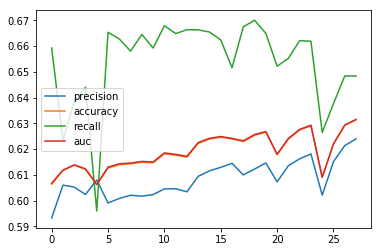

Best Params = {'max_depth': 18, 'n_estimators': 100}

Running for XGB Classifier
best_precision: 0.72597421, precision_based_on_best_auc: 0.63627347
best_accuracy: 0.63741412, accuracy_based_on_best_auc: 0.63741412
best_recall: 0.65286195, recall_based_on_best_auc: 0.62986541
best_auc: 0.63736171, auc_based_on_best_auc: 0.63736171


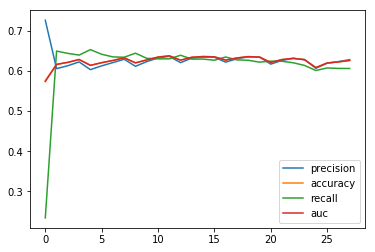

Best Params = {'max_depth': 5, 'n_estimators': 100}



In [96]:
models = {}
weights = {}
for classifier in classifier_dict.keys():
    model = run_model(classifier, x_train, y_train)
    values = {k: v for k, v in zip(in_model.keys(), model.best_estimator_.feature_importances_)}
    result = {k: values[k] for v, k in enumerate(sorted(values, key=values.get, reverse=True))}
    weights[classifier] = result
    models[classifier] = model

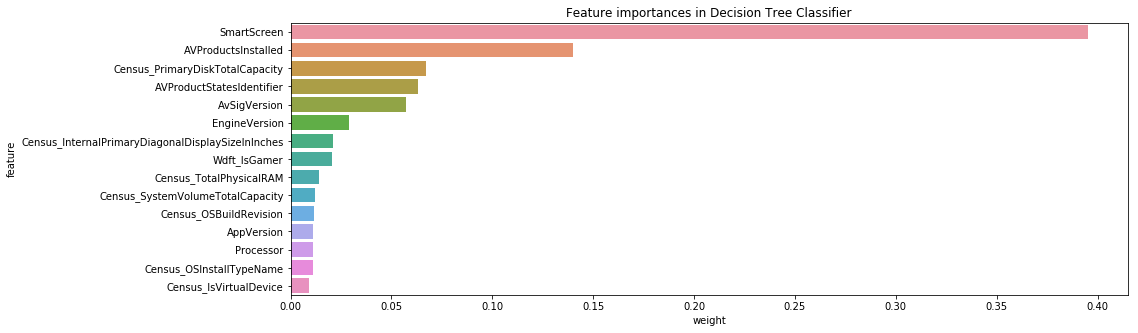

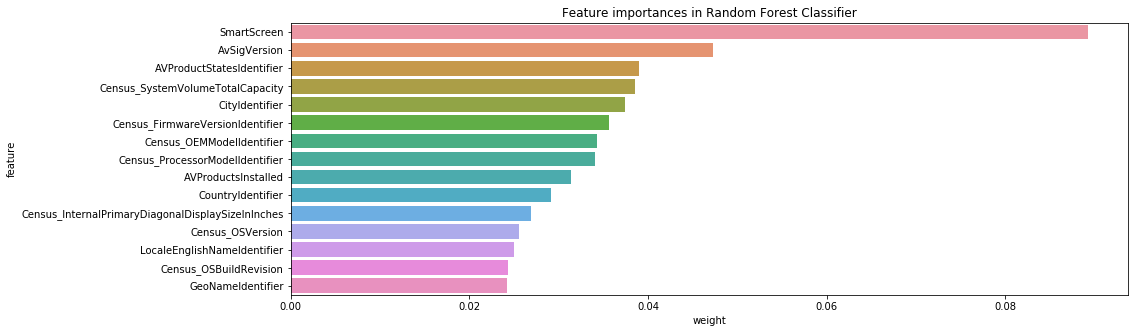

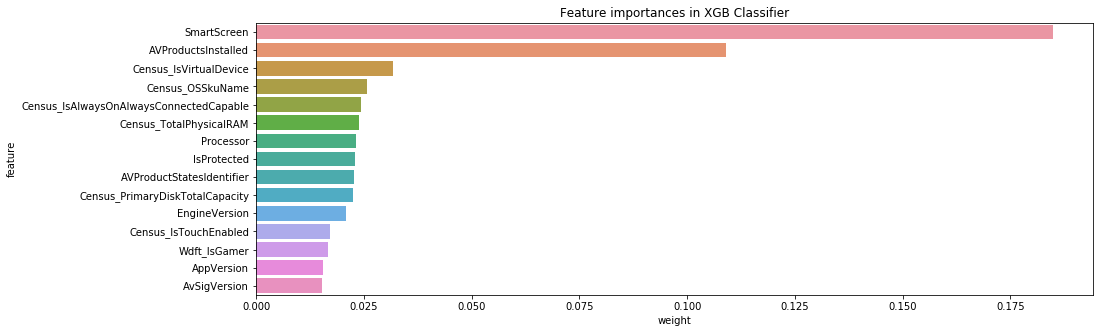

In [101]:
for classifier, weight in weights.items():
    weight_df = pd.DataFrame.from_dict(weight, orient='index', columns=['weight']).sort_values('weight', ascending=False)
    weight_df['feature'] = weight_df.index
    bar(weight_df.head(15), 'weight', 'feature', "Feature importances in %s" % classifier_names[classifier])

Both criteria are pretty similar so we are going to try with Spark to take more rows in our model increasing values for param grid.

## Let's predict!!

In [102]:
sample_test_df = utils.get_sample(test_df_transformed, x_fields + [y_field], sample_size)

In [103]:
x_test, y_test = utils.get_x_y_train(sample_test_df, x_fields, y_field)

In [106]:
for classifier in models.keys():
    score = models[classifier].score(x_test, y_test)
    print("roc_auc score for %s: %s" % (classifier_names[classifier], str(score)))

roc_auc score for Decision Tree Classifier: 0.6116690202693933
roc_auc score for Random Forest Classifier: 0.6346913204715435
roc_auc score for XGB Classifier: 0.6342990696779067


In [107]:
fields = {}
for classifier in weights.keys():
    classifier_fields = []
    for k, v in weights[classifier].items():
        if v >= cut_at:
            classifier_fields.append(k)
    fields[classifier] = classifier_fields

In [108]:
print("Fields in Random Forest not present in XGB: \n")
print(', '.join(list(set(fields['rfc']) - set(fields['xgb']))))
print("\nFields in XGB not present in Random Forest: \n")
print(', '.join(list(set(fields['xgb']) - set(fields['rfc']))))
print("\nFields present in XGB and Random Forest: \n")
print(', '.join(list(set(fields['xgb']) and set(fields['rfc']))))

Fields in Random Forest not present in XGB: 

Census_FirmwareVersionIdentifier, Census_InternalPrimaryDisplayResolutionHorizontal, Census_SystemVolumeTotalCapacity, Wdft_RegionIdentifier, Census_OSUILocaleIdentifier, Census_OSBuildRevision, Census_ChassisTypeName, Census_OEMModelIdentifier, Census_InternalBatteryNumberOfCharges, GeoNameIdentifier, IeVerIdentifier, Census_ProcessorModelIdentifier, Census_OSVersion, Census_OEMNameIdentifier, Census_OSInstallLanguageIdentifier, CityIdentifier, OrganizationIdentifier, CountryIdentifier, Census_FirmwareManufacturerIdentifier, Census_InternalPrimaryDisplayResolutionVertical, LocaleEnglishNameIdentifier

Fields in XGB not present in Random Forest: 

Processor, DefaultBrowsersIdentifier, Wdft_IsGamer, IsProtected, Census_IsVirtualDevice, Census_OSSkuName, Census_IsWIMBootEnabled, Census_IsAlwaysOnAlwaysConnectedCapable, OsBuild, Census_IsTouchEnabled, RtpStateBitfield

Fields present in XGB and Random Forest: 

AVProductsInstalled, AppVersion,

# After exploration, optimization

After a first step of exploratory, we find best results on a classification with a model based on Random Forest and with XGBoost.

For a better training, we have opted to use the algorithms implemented in Spark, using SparkML, for a better visualization in a notebook.

But in PySpark isn't implemented yet an algorithm to use XGBoost, so we are going to implement a Random Forest Classificator to get a better model with all the data.

In [25]:
try:
    rfc_fields = fields['rfc']
except:
    rfc_fields = list(set("Census_SystemVolumeTotalCapacity, OsBuildLab, AppVersion, Census_FirmwareManufacturerIdentifier, Census_OSBuildRevision, Census_OEMModelIdentifier, AvSigVersion, GeoNameIdentifier, Census_OSInstallLanguageIdentifier, Census_InternalBatteryNumberOfCharges, Census_PrimaryDiskTotalCapacity, Wdft_IsGamer, SmartScreen, Wdft_RegionIdentifier, CountryIdentifier, Census_OSInstallTypeName, AVProductsInstalled, Census_ProcessorModelIdentifier, EngineVersion, Census_OEMNameIdentifier, Census_OSUILocaleIdentifier, Census_InternalPrimaryDisplayResolutionHorizontal, Census_FirmwareVersionIdentifier, IeVerIdentifier, Census_InternalPrimaryDiagonalDisplaySizeInInches, AVProductStatesIdentifier, Census_OSVersion, LocaleEnglishNameIdentifier, CityIdentifier, Census_TotalPhysicalRAM, Census_SystemVolumeTotalCapacity, OsBuildLab, Census_FirmwareManufacturerIdentifier, Census_OSBuildRevision, Census_OEMModelIdentifier, AvSigVersion, GeoNameIdentifier, Census_OSInstallLanguageIdentifier, Census_InternalBatteryNumberOfCharges, Census_PrimaryDiskTotalCapacity, CountryIdentifier, Census_OSInstallTypeName, Census_ProcessorModelIdentifier, Census_OEMNameIdentifier, Census_OSUILocaleIdentifier, Census_InternalPrimaryDisplayResolutionHorizontal, Census_FirmwareVersionIdentifier, IeVerIdentifier, Census_InternalPrimaryDiagonalDisplaySizeInInches, Census_OSVersion, LocaleEnglishNameIdentifier, CityIdentifier, Wdft_RegionIdentifier".split(", ")))

In [26]:
train_df_small = train_df.sample(sample_size)

In [27]:
if not train_df_transformed:
    train_df_transformed = transform_df(train_df_small)

In [28]:
if not test_df_transformed:
    test_df_transformed = transform_df(test_df)

In [29]:
assembler = VectorAssembler(inputCols=rfc_fields, outputCol="features")

In [30]:
train_df_assembler = assembler.transform(train_df_transformed)
train_df_features = train_df_assembler.select(column_id, "features", y_field)

In [31]:
test_df_assembler = assembler.transform(test_df_transformed)
test_df_features = test_df_assembler.select(column_id, "features", y_field)

In [32]:
random_forest_classifer = RFC(labelCol = y_field, featuresCol = "features")
pipeline_rfc = Pipeline(stages = [random_forest_classifer])

In [54]:
rfc_spark = {
    'maxDepth': [25],
    'numTrees': [150, 200]
}

In [33]:
param_grid = ParamGridBuilder() \
   .addGrid(random_forest_classifer.maxDepth, rfc_spark["maxDepth"]) \
   .addGrid(random_forest_classifer.numTrees, rfc_spark["numTrees"]) \
   .build()

In [34]:
binary_classification_evaluator = BinaryClassificationEvaluator(labelCol = y_field,
                                                                metricName = "areaUnderROC") 

cross_validator = CrossValidator(estimator = pipeline_rfc,
                          estimatorParamMaps = param_grid,
                          evaluator = binary_classification_evaluator,
                          numFolds = cv)

In [35]:
cvModel = cross_validator.fit(train_df_features)

In [36]:
prediction = cvModel.transform(test_df_features)


In [39]:
prediction.select(column_id, y_field, "probability", "prediction").show(truncate=False)

+--------------------------------+-------------+----------------------------------------+----------+
|MachineIdentifier               |HasDetections|probability                             |prediction|
+--------------------------------+-------------+----------------------------------------+----------+
|000014a5f00daa18e76b81417eeb99fc|1            |[0.4355183532091269,0.5644816467908731] |1.0       |
|000024872c81cf03fa862aa8f99e0984|0            |[0.35728432104303104,0.6427156789569689]|1.0       |
|000028150912f45b1dc667164de489ef|0            |[0.6263439513769185,0.37365604862308155]|0.0       |
|00002c6cccecdef94aaa557d0458ab8a|1            |[0.5293285268236236,0.4706714731763764] |0.0       |
|0000422df51e713f82b98e04cb883cb5|1            |[0.3882333711464577,0.6117666288535424] |1.0       |
|00005c68016eab19fb33bdaa8a1d8bb7|0            |[0.5703847436043502,0.42961525639564974]|0.0       |
|000069097eaa0e375996f266eead5f5e|1            |[0.5208856956905539,0.47911430430944607]|0.

In [65]:
combis = itertools.product(*[each for each in rfc_spark.values()])

In [66]:
for (param1, param2), v in zip(combis, cvModel.avgMetrics):
    print("numTress: %s, maxDeepth: %s -> roc_auc: %s" % (str(param1), str(param2), str(v)))

numTress: 25, maxDeepth: 150 -> roc_auc: 0.684022305849406
numTress: 25, maxDeepth: 200 -> roc_auc: 0.6850227439371571
